In [1]:
import pandas as pd 
import numpy as np 
import  seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

### Read dataframe

In [2]:
# read preprocessed dataframe 
df = pd.read_csv('cleandata_mood.csv', sep = "\t", index_col=0)
df = df.fillna(df.mean()) #i had missing value replace your df here 
df.head(n=2)

,time,screen,activity,total_app_time,circumplex.arousal,circumplex.valence,call_sms,mood,Day_name,is_weekday,moodmean_5days,moodpreviousday,moodnextday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
id,,,,,,,,,,,,,,,,,,,,
AS14.01,2014-02-26,12088.324244,0.092498,11327.579489,-0.25,0.750000,3.0,6.250000,Wednesday,1,6.991076,6.990055,6.333333,0,0,0,0,0,0,1
AS14.01,2014-02-27,12088.324244,0.092498,11327.579489,0.00,0.333333,0.0,6.333333,Thursday,1,6.991076,6.250000,6.200000,0,0,0,0,1,0,0


#### Define targets  & hyperparameters

In [3]:
# list of columns you want to drop from x matrix ( this is just example) always call df as df 
dropcols = ['time', 'Day_name', 'moodpreviousday', 'mood','is_weekday','moodnextday'] 
target = 'moodnextday' # target you want to predict 
test_size = 0.2 # 20 % data as test set 

In [4]:
# Define your hyperparameters
n_estimaters = [int(x) for x in np.linspace(start = 10 , stop = 100 , num = 10)]
max_depth = [2,4]
max_features = ['auto', 'sqrt']

#set parameter grid for hyper parameter tuning 
param_grid = {"n_estimators" : n_estimaters,
             "max_depth" : max_depth,
             "max_features" : max_features}
print(param_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth': [2, 4], 'max_features': ['auto', 'sqrt']}


#### Define all the required function 

In [5]:

# these function is access within rfmodel but you can use it separatetly
#train test split 
def get_train_test(df, dropcols, target, test_size):
    """this function will take raw dataframe 
    and gives you train and test for model building """
    X = df.drop(dropcols, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=10)
    return X_train, X_test, y_train, y_test 

#parameter tuning 

def param_tuning(X_train, X_test, y_train, y_test):
    """ this function will return best parameters"""
    rfr = RandomForestRegressor() # initialize model with no parameters 
    rf_tune = RandomizedSearchCV(rfr, param_distributions=param_grid,
                              cv = 5, verbose =2 , n_jobs=4)
    rf_tune.fit(X_train, y_train)
    print(f'Train Accuracy - : {rf_tune.score(X_train, y_train):.3f}')
    print(f'Test Accuracy - : {rf_tune.score(X_test, y_test):.3f}')
    return rf_tune.best_params_
#how to run 
#best_param = param_tuning(X_train, X_test, y_train, y_test)

# final model you should run this command only
def rfmodel():
    '''run rf model and hyperparameter'''
    X_train, X_test, y_train, y_test = get_train_test(df=df,
                                                      dropcols =dropcols,
                                                      target = target,
                                                      test_size = test_size)
    best_params = param_tuning(X_train, X_test, y_train, y_test)
    
    #fit best model 
    n_estimator = best_params['n_estimators']
    max_feature = best_params['max_features']
    max_dept = best_params['max_depth']
    bestmodel = RandomForestRegressor(n_estimators=n_estimator,
                                      max_features=max_feature,
                                      max_depth = max_dept,
                                      random_state = 10)
    bestmodel.fit(X_train, y_train)
    y_pred = bestmodel.predict(X_test)
    #get performance stats 
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    #get feature importance 
    feat_importance = pd.Series(bestmodel.feature_importances_, 
                                 index=X_train.columns)
    #feat_importance.nlargest(X_train.columns).plot(kind='barh', color = 'darkblue')
    
    return [bestmodel, mse, r2, feat_importance] # this return list of factors

 # how to run results = rfmodel()   # access model results[0], access mse = results[1]

In [6]:
results = rfmodel()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train Accuracy - : 0.258
Test Accuracy - : 0.234


In [7]:
results

[RandomForestRegressor(max_depth=2, n_estimators=50, random_state=10),
 0.4898879188289417,
 0.2380673275183366,
 screen                0.003310
 activity              0.023988
 total_app_time        0.002554
 circumplex.arousal    0.010162
 circumplex.valence    0.000000
 call_sms              0.006620
 moodmean_5days        0.949576
 Friday                0.003789
 Monday                0.000000
 Saturday              0.000000
 Sunday                0.000000
 Thursday              0.000000
 Tuesday               0.000000
 Wednesday             0.000000
 dtype: float64]

<AxesSubplot:>

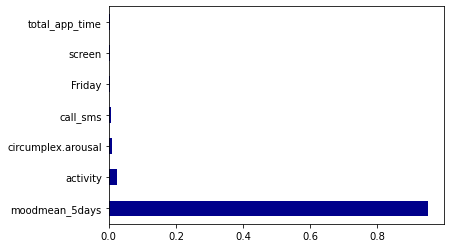

In [8]:
# visualize top 7 features  ( 3 is third place in list where feature importance stored)
results[3].nlargest(7).plot(kind='barh', color = 'darkblue')

#### how to access value from results
 - model = results[0]
 - mse = results[1]
 - r2 = results[2]
 - impfeatures = results[3]